In [ ]:
from google.colab import drive

In [ ]:
import  pandas as pd

In [ ]:
path = "/content/data_2020_2023_5min.csv"
df = pd.read_csv(path)

In [ ]:
df['datetime'] = pd.to_datetime(df['datetime']).dt.strftime('%Y-%m-%dT%H:%M:%S.000Z')

In [ ]:
df1 = df.rename(columns={
    'datetime': 'Date Time',
    'open': 'Open',
    'high': 'High',
    'low': 'Low',
    'close': 'Close',
    'volume': 'Volume'
})

In [ ]:
df1.head()

,Date Time,Open,High,Low,Close,Volume
0,2020-01-01T05:30:00.000Z,7195.24,7196.25,7178.64,7179.78,95.509133
1,2020-01-01T05:35:00.000Z,7179.76,7191.77,7178.20,7191.07,59.365225
2,2020-01-01T05:40:00.000Z,7193.15,7193.53,7180.24,7180.97,48.068510
3,2020-01-01T05:45:00.000Z,7180.97,7186.40,7177.35,7178.29,32.192929
4,2020-01-01T05:50:00.000Z,7177.71,7182.46,7175.47,7176.96,49.027397


In [ ]:
df1.to_csv('data.csv', index=False)

In [ ]:
from pyalgotrade import strategy
from pyalgotrade.technical import ma

class MACrossoverStrategy(strategy.BacktestingStrategy):

    def __init__(self, feed, instrument, broker, fastMA, slowMA, takeProfitMultiplier, stopMultiplier):
        super(MACrossoverStrategy, self).__init__(feed, broker)
        self.__instrument = instrument
        self.__fast_ma = ma.SMA(feed[instrument].getPriceDataSeries(), fastMA)
        self.__slow_ma = ma.SMA(feed[instrument].getPriceDataSeries(), slowMA)
        self.__takeProfitMultiplier = takeProfitMultiplier
        self.__stopMultiplier = stopMultiplier

        self.__takeProfitPrice = None
        self.__stopPrice = None
        self.__position = None
        self.__lastTrend = None

    def getFastSMA(self):
        return self.__fast_ma

    def getSlowSMA(self):
        return self.__slow_ma

    def onBars(self, bars):
        if self.__fast_ma[-1] is None or self.__slow_ma[-1] is None:
            return

        bar = bars[self.__instrument]
        if self.__position is None:
            if self.__fast_ma[-1] > self.__slow_ma[-1] and self.__lastTrend != 'BULL':
                self.__position = self.enterLong(self.__instrument, 1, True)
                self.__takeProfitPrice = bar.getPrice() * (1 + self.__takeProfitMultiplier)
                self.__stopPrice = bar.getPrice() * (1 - self.__stopMultiplier)
                self.__lastTrend = 'BULL'

            elif self.__fast_ma[-1] < self.__slow_ma[-1] and self.__lastTrend != 'BEAR':
                self.__position = self.enterShort(self.__instrument, 1, True)
                self.__takeProfitPrice = bar.getPrice() * (1 - self.__takeProfitMultiplier)
                self.__stopPrice = bar.getPrice() * (1 + self.__stopMultiplier)
                self.__lastTrend = 'BEAR'
        else:
            if self.__position.getShares() > 0:
                if bar.getPrice() > self.__takeProfitPrice or bar.getPrice() < self.__stopPrice:
                    self.__position.exitMarket()
                    self.__position = None
            elif self.__position.getShares() < 0:
                if bar.getPrice() < self.__takeProfitPrice or bar.getPrice() > self.__stopPrice:
                    self.__position.exitMarket()
                    self.__position = None

INFO:strategy:Final portfolio value: $1499437.7631789944
2024-09-28 10:35:06,073 strategy [INFO] Final portfolio value: $1499437.7631789944


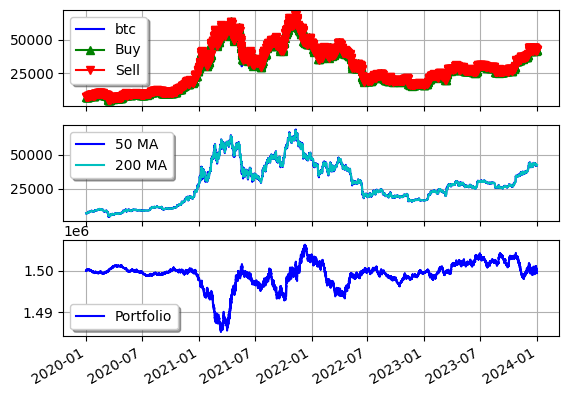

In [ ]:
from pyalgotrade.barfeed import csvfeed
from pyalgotrade.broker import backtesting
from pyalgotrade import plotter
def run_strategy(fastSma, slowSma, tp, stop):
    feed = csvfeed.GenericBarFeed(frequency=60*5)
    feed.setDateTimeFormat("%Y-%m-%dT%H:%M:%S.%fZ")
    feed.addBarsFromCSV("btc", "data.csv")
    commission = backtesting.TradePercentage(0.0001)
    broker = backtesting.Broker(1500000, feed, commission)
    myStrategy = MACrossoverStrategy(feed, "btc", broker, fastSma, slowSma, tp, stop)
    plt = plotter.StrategyPlotter(myStrategy)
    plt.getOrCreateSubplot("MA").addDataSeries("50 MA", myStrategy.getFastSMA())
    plt.getOrCreateSubplot("MA").addDataSeries("200 MA", myStrategy.getSlowSMA())
    myStrategy.run()
    myStrategy.info(f'Final portfolio value: ${myStrategy.getResult()}')
    plt.plot()

run_strategy(50, 200, 0.018, 0.003)

In [ ]:
from pyalgotrade import strategy
from pyalgotrade.technical import rsi

class RSIStrategy(strategy.BacktestingStrategy):

    def __init__(self, feed, instrument, broker, rsiPeriod, overbought, oversold):
        super(RSIStrategy, self).__init__(feed, broker)
        self.__instrument = instrument
        self.__rsi = rsi.RSI(feed[instrument].getPriceDataSeries(), rsiPeriod)
        self.__overbought = overbought
        self.__oversold = oversold
        self.__position = None

    def getRsi(self):
        return self.__rsi

    def onBars(self, bars):
        if self.__rsi[-1] is None:
            return

        bar = bars[self.__instrument]
        if self.__position is None:
            if self.__rsi[-1] < self.__oversold:
                self.__position = self.enterLong(self.__instrument, 1, True)
        elif self.__position.getShares() > 0:
            if self.__rsi[-1] > self.__overbought:
                self.__position.exitMarket()
                self.__position = None


INFO:strategy:Final portfolio value: $1500933.928442007
2024-09-28 10:36:17,810 strategy [INFO] Final portfolio value: $1500933.928442007


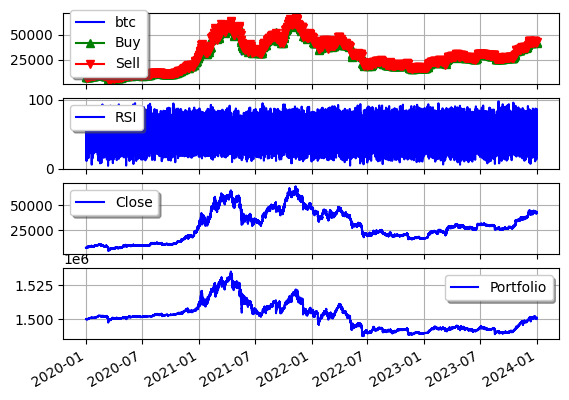

In [ ]:
def run_strategy(rsiPeriod, overbought, oversold):
    feed = csvfeed.GenericBarFeed(frequency=60*5)
    feed.setDateTimeFormat("%Y-%m-%dT%H:%M:%S.%fZ")
    feed.addBarsFromCSV("btc", "data.csv")
    commission = backtesting.TradePercentage(0.0001)
    broker = backtesting.Broker(1500000, feed, commission)
    myStrategy = RSIStrategy(feed, "btc", broker, rsiPeriod=rsiPeriod, overbought=overbought, oversold=oversold)
    plt = plotter.StrategyPlotter(myStrategy)
    plt.getOrCreateSubplot("RSI").addDataSeries("RSI", myStrategy.getRsi())
    plt.getOrCreateSubplot("Price").addDataSeries("Close", feed["btc"].getPriceDataSeries())
    myStrategy.run()
    myStrategy.info(f'Final portfolio value: ${myStrategy.getResult()}')
    plt.plot()
run_strategy(rsiPeriod=14, overbought=70, oversold=30)


In [ ]:
from pyalgotrade.barfeed import csvfeed
from pyalgotrade.broker import backtesting
from pyalgotrade import plotter
from pyalgotrade import strategy
from pyalgotrade.technical import ma, rsi

class MACrossoverStrategy(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument, broker, fastMA, slowMA, takeProfitMultiplier, stopMultiplier):
        super(MACrossoverStrategy, self).__init__(feed, broker)
        self.__instrument = instrument
        self.__fast_ma = ma.SMA(feed[instrument].getPriceDataSeries(), fastMA)
        self.__slow_ma = ma.SMA(feed[instrument].getPriceDataSeries(), slowMA)
        self.__takeProfitMultiplier = takeProfitMultiplier
        self.__stopMultiplier = stopMultiplier
        self.__position = None
        self.__lastTrend = None

    def getFastSMA(self):
        return self.__fast_ma

    def getSlowSMA(self):
        return self.__slow_ma

    def onBars(self, bars):
        if self.__fast_ma[-1] is None or self.__slow_ma[-1] is None:
            return

        bar = bars[self.__instrument]
        if self.__position is None:
            if self.__fast_ma[-1] > self.__slow_ma[-1]:
                self.__position = self.enterLong(self.__instrument, 0.1)
            elif self.__fast_ma[-1] < self.__slow_ma[-1]:
                self.__position = self.enterShort(self.__instrument, 0.0001)
        else:
            if self.__position.getShares() > 0 and bar.getPrice() < self.__fast_ma[-1]:
                self.__position.exitMarket()
                self.__position = None
            elif self.__position.getShares() < 0 and bar.getPrice() > self.__fast_ma[-1]:
                self.__position.exitMarket()
                self.__position = None


class RSIStrategy(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument, broker, rsiPeriod, overbought, oversold):
        super(RSIStrategy, self).__init__(feed, broker)
        self.__instrument = instrument
        self.__rsi = rsi.RSI(feed[instrument].getPriceDataSeries(), rsiPeriod)
        self.__overbought = overbought
        self.__oversold = oversold
        self.__position = None

    def getRsi(self):
        return self.__rsi

    def onBars(self, bars):
        if self.__rsi[-1] is None:
            return

        bar = bars[self.__instrument]
        if self.__position is None and self.__rsi[-1] < self.__oversold:
            self.__position = self.enterLong(self.__instrument, 0.001)
        elif self.__position is not None and self.__rsi[-1] > self.__overbought:
            self.__position.exitMarket()
            self.__position = None


def run_strategy(fastSma, slowSma, tp, stop, rsiPeriod, overbought, oversold):
    feed = csvfeed.GenericBarFeed(frequency=60*5)
    feed.setDateTimeFormat("%Y-%m-%dT%H:%M:%S.%fZ")
    feed.addBarsFromCSV("btc", "data.csv")

    commission = backtesting.TradePercentage(0.0001)
    broker = backtesting.Broker(15000000000, feed, commission)
    ma_strategy = MACrossoverStrategy(feed, "btc", broker, fastSma, slowSma, tp, stop)
    rsi_strategy = RSIStrategy(feed, "btc", broker, rsiPeriod, overbought, oversold)
    plt = plotter.StrategyPlotter(ma_strategy, plotAllInstruments=True)
    plt.getOrCreateSubplot("MA").addDataSeries("Fast MA", ma_strategy.getFastSMA())
    plt.getOrCreateSubplot("MA").addDataSeries("Slow MA", ma_strategy.getSlowSMA())
    plt.getOrCreateSubplot("RSI").addDataSeries("RSI", rsi_strategy.getRsi())
    plt.getOrCreateSubplot("Price").addDataSeries("Close", feed["btc"].getPriceDataSeries())
    ma_strategy.run()
    rsi_strategy.run()
    ma_strategy.info(f'Final MA portfolio value: ${ma_strategy.getResult()}')
    rsi_strategy.info(f'Final RSI portfolio value: ${rsi_strategy.getResult()}')
    plt.plot()
run_strategy(fastSma=50, slowSma=200, tp=0.018, stop=0.003, rsiPeriod=14, overbought=70, oversold=30)


Streaming output truncated to the last 5000 lines.
2024-09-28 10:40:08,158 broker.backtesting [DEBUG] Not enough volume to fill btc market order [363] for 0 share/s
DEBUG:broker.backtesting:Not enough volume to fill btc market order [363] for 0 share/s
2024-09-28 10:40:08,160 broker.backtesting [DEBUG] Not enough volume to fill btc market order [363] for 0 share/s
DEBUG:broker.backtesting:Not enough volume to fill btc market order [363] for 0 share/s
2024-09-28 10:40:08,162 broker.backtesting [DEBUG] Not enough volume to fill btc market order [363] for 0 share/s
DEBUG:broker.backtesting:Not enough volume to fill btc market order [363] for 0 share/s
2024-09-28 10:40:08,164 broker.backtesting [DEBUG] Not enough volume to fill btc market order [363] for 0 share/s
DEBUG:broker.backtesting:Not enough volume to fill btc market order [363] for 0 share/s
2024-09-28 10:40:08,166 broker.backtesting [DEBUG] Not enough volume to fill btc market order [363] for 0 share/s
DEBUG:broker.backtesting:No

KeyboardInterrupt: 